In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
from argparse import Namespace

import jax.numpy as jnp
from jax import grad, jit
from jax_md import space, partition
from jax.test_util import check_grads
import copy

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

from cases import select_case
from jax_sph.solver import WCSPH
from jax_sph.integrator import si_euler
from jax_sph.utils import pos_init_cartesian_2d

2024-02-11 11:49:49.941416: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
CASES = ["TGV", "LDC"]
STEPS = 5
WARMUP = 10
N = 20

dx = 1.0 / N
dt = 0.0

FD_EPS = 0.001 * dx  # np.sqrt(np.finfo(float).eps)

In [3]:
def naive_fd_grad(fn, state, neighbors):
    r = state["r"]

    def fn_(x):
        state_ = state.copy()
        state_["r"] = x
        return fn(state_, neighbors)

    actual_grad = jnp.zeros_like(r)
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            f_left = fn_(r)
            f_right = fn_(r.at[i, j].set(r[i, j] + FD_EPS))
            actual_grad = actual_grad.at[i, j].set((f_right - f_left) / FD_EPS)
    return actual_grad


def scipy_fd_grad(fn, state, neighbors):
    shape = state["r"].shape
    r = np.array(state["r"]).flatten()

    def fn_(x):
        state_ = state.copy()
        state_["r"] = jnp.array(x.reshape(*shape))
        return np.array(fn(state_, neighbors)).flatten()

    grads = sp.optimize.approx_fprime(xk=r, f=fn_, epsilon=FD_EPS)
    grads = jnp.array(grads).reshape(*shape)
    return grads

In [5]:
sph_grads = {}
fd_grads = {}
case_shapes = {}

for case_id in CASES:
    args = Namespace(
        seed=0,
        case=case_id,
        viscosity=0.1,
        dx=dx,
        dt=dt,
        t_end=1.0,
        dim=2,
        p_bg_factor=None,
        g_ext_magnitude=None,
        r0_noise_factor=0.0,
        solver="SPH"
    )

    Case = select_case(args.case)
    # mokney patch case(args)._init_pos2D to return a cartesian grid
    case = Case(args)
    case._init_pos2D = pos_init_cartesian_2d
    args, box_size, state, g_ext_fn, bc_fn, eos_fn, key = case.initialize()

    dt = args.dt
    displ_fn, shift_fn = space.periodic(box_size)

    neighbor_fn = partition.neighbor_list(
        displ_fn, box_size, 0.15, format=partition.Sparse
    )
    neighbors = neighbor_fn.allocate(state["r"], num_particles=state["r"].shape[0])

    model = WCSPH(displ_fn, eos_fn, g_ext_fn, dx=dx, dim=2, dt=dt, c_ref=10)

    solver = si_euler(0.0, model, shift_fn, bc_fn)
    solver = jit(solver)

    # warm up initial state
    for _ in range(WARMUP):
        state, neighbors = solver(dt, state, neighbors)

    def solver_fn(state, neighbors):
        state_ = state.copy()
        neighbors_ = copy.deepcopy(neighbors)
        for _ in range(STEPS):
            state_, neighbors_ = solver(dt, state_, neighbors_)
        return (0.5 * state_["u"] ** 2).sum()

    # state_ = copy.deepcopy(state)
    # neighbors_ = copy.deepcopy(neighbors)
    # try:
    #     def check_solver_fn(x):
    #         state_["r"] = x.reshape(*state_["r"].shape)
    #         return solver_fn(state_, neighbors_)
    #     check_grads(check_solver_fn, (state_["r"],), order=1, modes=["fwd", "rev"], atol=1e-3, rtol=1e-3)
    # except Exception as e:
    #     print(f"[{case_id}] Gradient mismatch: {e}")

    sph_grad = grad(solver_fn, argnums=(0,), allow_int=True)(state, neighbors)[0]["r"]

    fd_grad = scipy_fd_grad(solver_fn, state, neighbors)
    err = ((sph_grad - fd_grad) ** 2).mean()

    sph_grads[case_id] = sph_grad
    fd_grads[case_id] = fd_grad
    ratio = box_size[1] / box_size[0]
    num = int(state["r"].shape[0] ** 0.5) if ratio == 1 else N
    case_shapes[case_id] = (num, int(num * ratio))

    print(f"[{case_id}] Total error (scipy FD) = {err:.6f}")

Using gamma_EoS=1.0.
dt_convective : 0.0011363636363636365
dt_viscous    : 0.006250000000000001
dt_body_force : 3751499.544919711
dt_max        : 0.0011363636363636365
dt_final      : 0.0011363636363636365
Total number of particles =  400
[TGV] Total error (scipy FD) = 0.023935
Using gamma_EoS=1.0.
dt_convective : 0.0011363636363636365
dt_viscous    : 0.006250000000000001
dt_body_force : 3751499.544919711
dt_max        : 0.0011363636363636365
dt_final      : 0.0011363636363636365
Total number of particles =  676
[LDC] Total error (scipy FD) = 0.039873


## Gradient landscapes

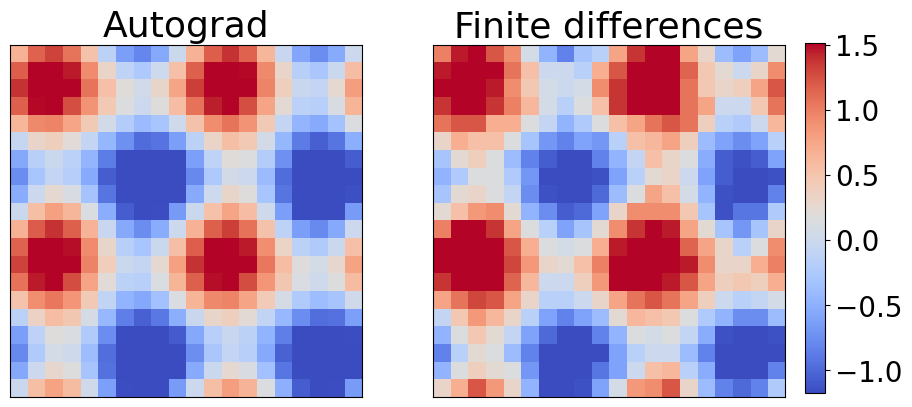

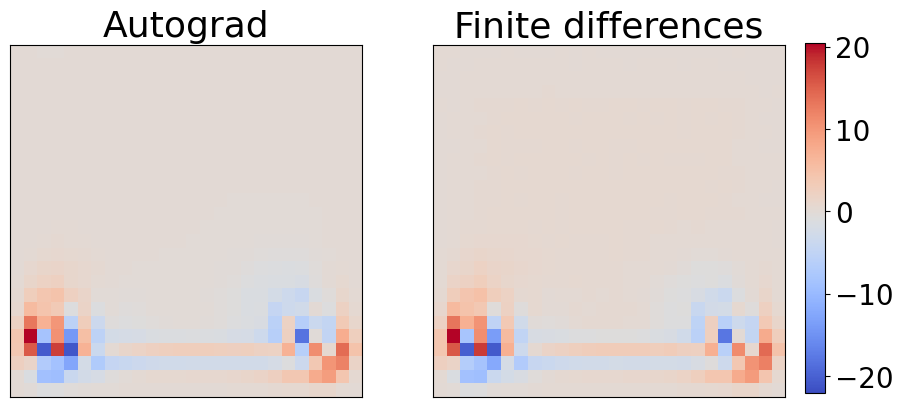

In [6]:
for case_id in sph_grads:
    sph_grad = sph_grads[case_id]
    fd_grad = fd_grads[case_id]
    shape = case_shapes[case_id]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # fig.tight_layout()

    vmin = min(sph_grad.min(), fd_grad.min())
    vmin = vmin * 1.1 if vmin < 0 else vmin * 0.9
    vmax = max(sph_grad.max(), fd_grad.max())
    vmax = vmax * 1.1 if vmax > 0 else vmax * 0.9

    axs[0].imshow(sph_grad.sum(1).reshape(shape), cmap="coolwarm", vmin=vmin, vmax=vmax)
    axs[0].set_title("Autograd", fontsize=26)
    axs[1].imshow(fd_grad.sum(1).reshape(shape), cmap="coolwarm", vmin=vmin, vmax=vmax)
    axs[1].set_title("Finite differences", fontsize=26)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    # colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=20)

    plt.savefig(
        f"grad_comparison_{case_id}.pdf", bbox_inches="tight", pad_inches=0.1, dpi=300
    )